<a href="https://colab.research.google.com/github/fedenemi/Average_income_and_water_usage/blob/main/Water_and_income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**What Is The Correlation Between Per Capita Income And The Average Water Consumption Or Withdrawals At The County Level?**

**Dataset Sources**

https://www.johnsonmsgisportfolio.com/web-gis

https://water.usgs.gov/watuse/data/2010/datadict.html

https://www.sciencebase.gov/catalog/item/get/5af3311be4b0da30c1b245d8

https://en.wikipedia.org/wiki/List_of_United_States_counties_by_per_capita_income

In [1]:
#import libraries and set up notebook for matplotlib
%matplotlib
%matplotlib inline
import matplotlib as mlb
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd
import numpy as np
import io
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler    
from pandas.plotting import scatter_matrix

Using matplotlib backend: agg


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f176ba37c90>,
      dtype=object)

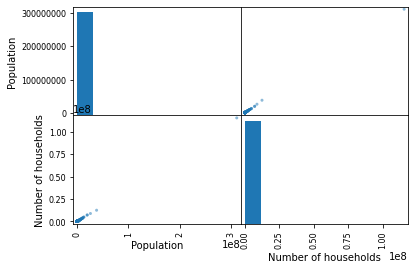

In [2]:
#get dataset and filter columns

table=pd.read_html("https://en.wikipedia.org/wiki/List_of_United_States_counties_by_per_capita_income")[2]
table.columns=['Rank', 'COUNTY',
       'State', 'Per capita income',
       'Median household income', 'Median family income', 'Population',
       'Number of households']

table.head()
scatter_matrix(table)

In [3]:
#upload csv file
a=files.upload()

Saving usco2015v2.0.csv to usco2015v2.0.csv


In [4]:
#read csv file and some cleaning

df=pd.read_csv(io.StringIO(a["usco2015v2.0.csv"].decode('utf-8')),header=None,skiprows=1) 

In [5]:
#data cleaning

df.columns = df.iloc[0]
df.drop(df.index[0], inplace=True)
df=df[['STATE', 'STATEFIPS', 'COUNTY', 'COUNTYFIPS','DO-PSPCp','DO-SSPCp','TO-Wtotl']]
df["COUNTY"]=df["COUNTY"].str.replace(" County", "")

table["Per capita income"]=table["Per capita income"].str.replace("\$", "")
table["Per capita income"]=table["Per capita income"].str.replace("\,", "")
table["Per capita income"]=table["Per capita income"].astype(float)

table["Median household income"]=table["Median household income"].str.replace("\$", "")
table["Median household income"]=table["Median household income"].str.replace("\,", "")
table["Median household income"]=table["Median household income"].astype(float)

table["Median family income"]=table["Median family income"].str.replace("\$", "")
table["Median family income"]=table["Median family income"].str.replace("\,", "")
table["Median family income"]=table["Median family income"].astype(float)


In [6]:
#merge both datasets (and more data cleaning)

merged=table.merge(df,how='outer', on="COUNTY")

merged["TO-Wtotl"]=merged["TO-Wtotl"].astype(float)
merged['DO-SSPCp']=merged['DO-SSPCp'].astype(float)
merged['DO-PSPCp']=merged['DO-PSPCp'].astype(float)

merged["Total water per capita"]=merged["TO-Wtotl"]/(merged["Population"]*0.00001)
merged.sort_values("Per capita income", ascending=False, inplace=True)


<Figure size 720x720 with 0 Axes>

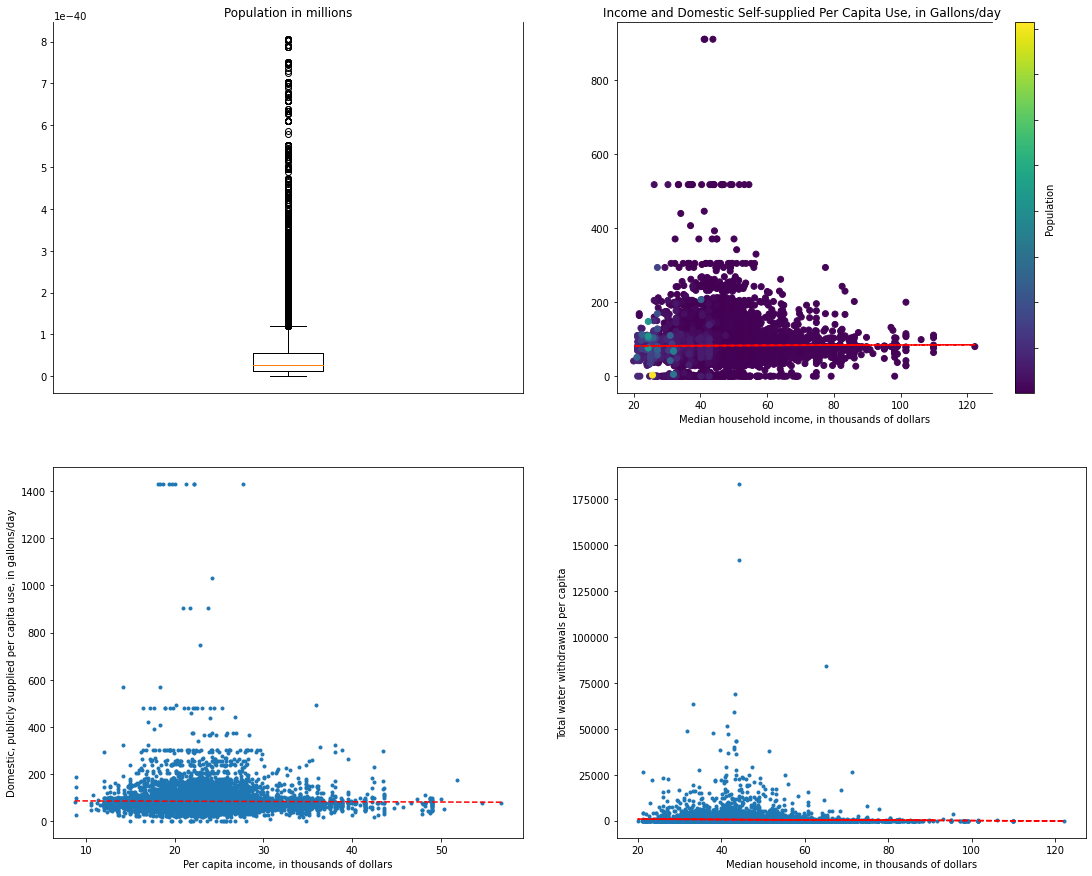

In [21]:
#plotting data (and more cleaning)



merged["Population"]=merged["Population"]/(10**5)
mhi=merged["Median household income"]/1000
pci=merged["Per capita income"]/1000
merged.dropna(inplace=True)

plt.figure(figsize=(10,10))
fig,((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(18.5, 15)


npop=merged[(np.abs(stats.zscore(merged["Population"])) < 3)]
col=[abs(colu) for colu in (StandardScaler().fit_transform(merged.sort_values("Population", ascending=True).Population.values.reshape(-1, 1)))]

#top left plot
ax1.cla()
ax1.set_title("Population in millions")
ax1.boxplot(npop.Population)
ax1.spines["top"].set_visible(False)
ax1.tick_params(labelbottom=False, top=False, bottom=False, left=True, right=False)





#top right plot
sc=ax2.scatter(merged["Median household income"]/1000,merged['DO-SSPCp'],c=col)
ax2.set_title("Income and Domestic Self-supplied Per Capita Use, in Gallons/day ")
ax2.set_xlabel("Median household income, in thousands of dollars")
ax2.spines["right"].set_visible(False)
z2 = np.polyfit(mhi,merged['DO-SSPCp'], 1)
p2= np.poly1d(z2)
ax2.plot(mhi,p2(mhi),"r--")

#build colorbar
cbar = fig.colorbar(sc, ax=ax2)
cbar.ax.set_yticklabels([])
cbar.set_label("Population")

#bottom left plot
ax3.plot(pci,merged['DO-PSPCp'],".")
ax3.set_xlabel("Per capita income, in thousands of dollars")
ax3.set_ylabel("Domestic, publicly supplied per capita use, in gallons/day")
z3 = np.polyfit(pci,merged['DO-PSPCp'], 1)
p3= np.poly1d(z3)
ax3.plot(pci,p3(pci),"r--")

#bottom right plot
ax4.plot(merged["Median household income"]/1000,merged["Total water per capita"],".")
ax4.set_xlabel("Median household income, in thousands of dollars")
ax4.set_ylabel("Total water withdrawals per capita")
z4 = np.polyfit(mhi,merged['Total water per capita'], 1)
p4= np.poly1d(z4)
ax4.plot(mhi,p4(mhi),"r--")

In the various plots above, we can get a useful portrait of the relationship between counties on the basis of per capita income and their respective water usage.

While the trend line doesn't seem to give us a useful novel idea that impacts our notion of a correlation. If we just focus on the scatter plot we can clearly see that the highest mean water usage takes place in lower income counties, which might give us a hint as to the importance of the scale of the household fiscal health, as opposed to plain population numbers, as seen in the information that the colorbar conveys, where it does not have a clear effect, and the irrelevance it seems to have coming from a context of wild statistical distribution that the boxplot shows. And we can also see the difference in the predominance of the type of economic activity and cultural habits as a cause of the mentioned disparity beyond the factor of the scale.

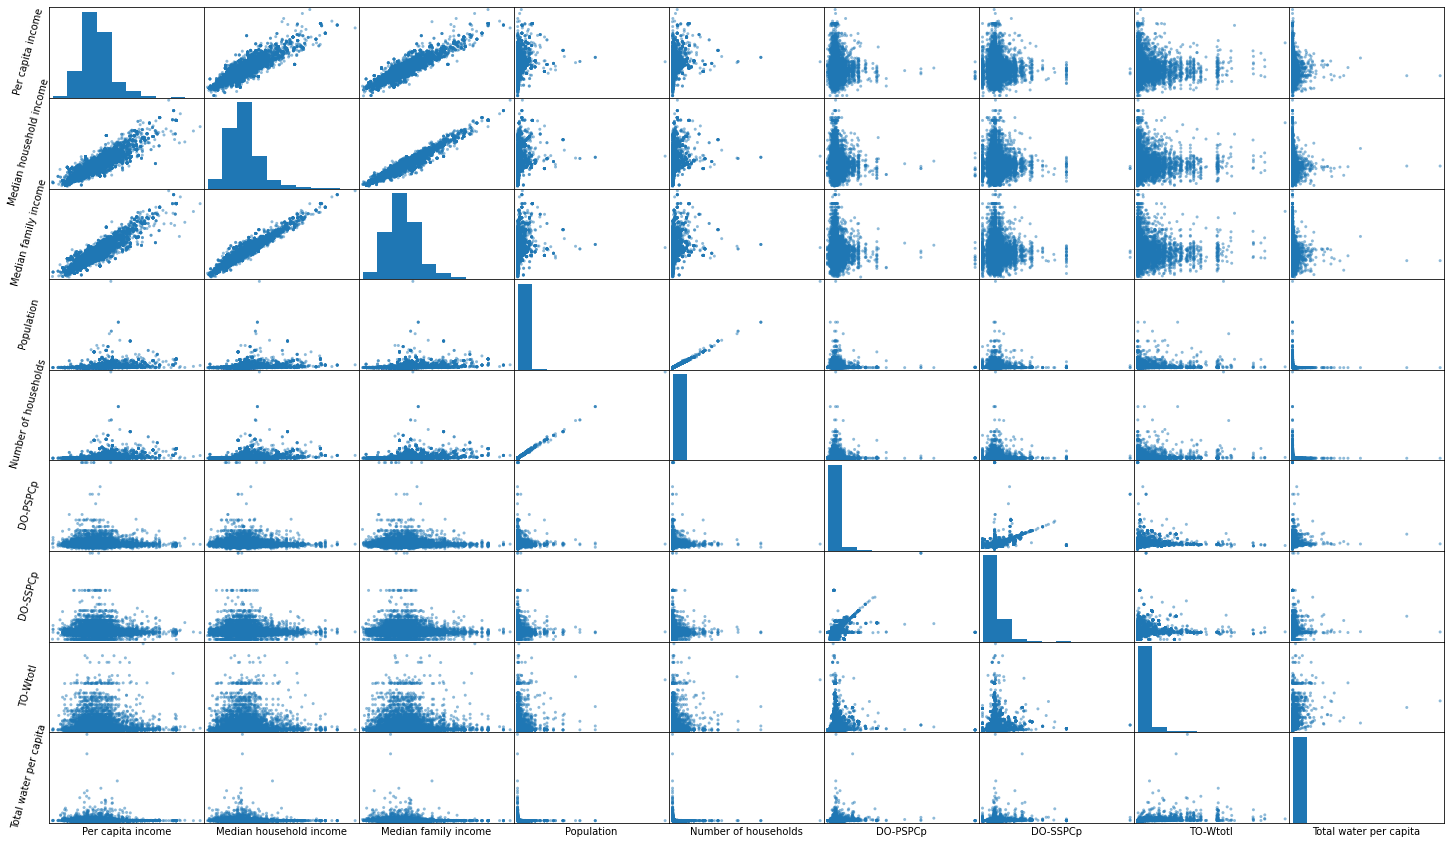

In [10]:
# a potentially useful, more general picture, with a scatter matrix

smat=scatter_matrix(merged,figsize=(25,15));
for subaxis in smat:
        for ax in subaxis:
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            ax.yaxis.label.set_size(10)
            ylab=ax.yaxis.label.get_text()
            ax.set_ylabel(ylab,rotation=75, labelpad=15)            


In [11]:
# sfig=smat[0][0].get_figure() 
# plt.savefig("water.png")
# files.download("water.png") 

In [12]:
#correlation

corr, pval=stats.pearsonr(merged["Median household income"],merged["Total water per capita"])
print("pval: "+ str(pval))
acorr, apval=stats.pearsonr(merged["Median household income"],merged['DO-SSPCp'])
print("apval: "+ str(apval))
bcorr, bpval=stats.pearsonr(merged["Median household income"],merged['DO-PSPCp'])
print("bpval: "+ str(bpval))
ccorr, cpval=stats.pearsonr(merged["Median household income"],merged["Number of households"])
print("cpval: "+ str(cpval))

pval: 0.00019941922224396132
apval: 0.40057904257193866
bpval: 0.1303221449958896
cpval: 6.987834173512724e-243


In [13]:
corr, pval=stats.pearsonr(merged["Per capita income"],merged["Total water per capita"])
print("pval: "+ str(pval))
acorr, apval=stats.pearsonr(merged["Per capita income"],merged['DO-SSPCp'])
print("apval: "+ str(apval))
bcorr, bpval=stats.pearsonr(merged["Per capita income"],merged['DO-PSPCp'])
print("bpval: "+ str(bpval))
ccorr, cpval=stats.pearsonr(merged["Per capita income"],merged["Number of households"])
print("cpval: "+ str(cpval))


pval: 0.050300991500559625
apval: 0.202135764807989
bpval: 0.23266391613435872
cpval: 2.487585e-317


**Conclution:**

To sum up, we can derive from the graphs (despite the lack of a clear trend line) and to a greater extent from the pearsonr() method, that there is a correlation between the average income of counties in the United States and certain measurements of water usage. Nonetheless, however counter-intuitive it might sound at first, it is in the places with the lowest income per-capita where the highest water withdrawals and domestic usage are found.

    
